# Simple housing model

Your task is to implement a simple model to predict home prices for a small real estate transactions dataset.

Instructions:
Predict the close price as of list date given the other attributes.
Build separate models with and without ListPrice.
Feel free to join the dataset to any other data sources, so long as they are not leaky.

Questions:
How would you improve your model?

## Load Libraries

In [3]:
%matplotlib inline

import numpy as np
import pandas as pd
import datetime as dt
import statistics as stat

from sklearn.ensemble import RandomForestRegressor
from sklearn.cross_validation import train_test_split
from sklearn import preprocessing  # or one-hot-outlier

#Regression Specific:
#from sklearn.metrics import classification_report
#from sklearn.metrics import (brier_score_loss, precision_score, recall_score,
#                             f1_score)
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt

In [2]:
## Load Data Set
df = pd.read_csv('data_sci_snippet.csv')  # , header=0
df.head(1)

,ListingId,LivingArea,NumBedrooms,NumBaths,Pool,ExteriorStories,ListDate,ListPrice,GeoLat,GeoLon,PublicRemarks,CloseDate,ClosePrice,ListingStatus,DwellingType
0,5077399,3054,4,2.5,Private,1,2014-03-04,675000,33.593239,-111.961056,This property OUTSTANDING offers outdoor livin...,NaN,NaN,Cancelled,Single Family - Detached


## Preprocessing

### Data Cleaning

In [3]:
## Conver Dates: str to Datetime
df['ListDate'] = pd.to_datetime(df['ListDate'])
df['CloseDate'] = pd.to_datetime(df['CloseDate'])
## Convert Dates: datetime to ordinals
df['CloseDateInt'] = df['CloseDate'].apply(lambda x: x.toordinal())
df['ListDateInt'] = df['ListDate'].apply(lambda x: x.toordinal())

In [4]:
## Living Area: If None, replace with median value, ideally from Zip or town 
df.LivingArea[df.LivingArea.isnull()] = stat.median(df['LivingArea'])
#df[df['ListingId'] == 5140687]  # Confirm NaN replaced with median
#df[df.LivingArea.isnull()]

-c:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [5]:
##GeoLat And GeoLon  # Bad Assumption, might get location from 'PublicRemarks'
df.GeoLat[df.GeoLat.isnull()] = stat.median(df['GeoLat'])
df.GeoLon[df.GeoLon.isnull()] = stat.median(df['GeoLon'])
#df.dtypes[df.dtypes.map(lambda x: x=='object')]

-c:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
-c:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


### Feature Engineering

In [6]:
## Add TimeToClose  # As time to close -> oo, ClosePrice decreases
df['TimeToClose'] = df['CloseDateInt'] - df['ListDateInt']

In [7]:
## Create ZipCode 
#df.loc[:,'ZipCode'] = np.empty(len(df))  #, dtype=int
#df['ZipCode'] = -1

In [8]:
## Add Zip code vector to data set
##    b/c long / lat doesn't define neighborhoods or school dist.
##    A dummy vector of the zip is better! Maybe.
### --> DANGER: this code takes a long time to run! <--

#from geopy.geocoders import Nominatim

#geolocator = Nominatim()

#for n in range(1601,1700+1):   #0,len(df2) #100=35s  500=2m:41s
#    try:
#        if df.loc[n,'ZipCode'] == -1 or df.loc[n,'ZipCode'] == None:
#            df.loc[n,'ZipCode'] = int(geolocator.reverse('{lat}, {long}'.format(lat=str(df.loc[n,'GeoLat']), long=str(df.loc[n,'GeoLon']))).raw['address']['postcode'])
#        else:
#            pass
#    except: df.loc[n,'ZipCode'] = -1


#import os; 
#os.system('say "Run complete!"');
#os.system('say beep');

In [9]:
## Debug Tools
#df.loc[2511,]
#df.loc[11:500,['ZipCode']]
#df.loc[1600:1610,['GeoLat','GeoLon','ZipCode']]
#df['ZipCode'].value_counts()
#df['GeoLat'].value_counts()

In [10]:
## Convert Categorical vectors to dummy (1-hot encoded) binary vectors 
### --> Proven less effective than a 0-n encoding based on utility
###        or avg. valuation.

def gen_dummies(dfColumn,columnName):
    data = pd.DataFrame({columnName: dfColumn})
    res = pd.get_dummies(data)
    return res

# Generate Dummy Vectors
poolDummies = gen_dummies(df['Pool'], 'Pool')  #list(df.columns.values)[4]
dwellingTypeDummies = gen_dummies(df['DwellingType'], 'DwellingType')  #list(df.columns.values)[14]

# Concatenate with df
df = pd.concat([df, poolDummies], axis=1, join_axes=[df.index])
df = pd.concat([df, dwellingTypeDummies], axis=1, join_axes=[df.index])
df.head(3)

,ListingId,LivingArea,NumBedrooms,NumBaths,Pool,ExteriorStories,ListDate,ListPrice,GeoLat,GeoLon,...,Pool_None,Pool_Private,DwellingType_Apartment Style/Flat,DwellingType_Gemini/Twin Home,DwellingType_Loft Style,DwellingType_Mfg/Mobile Housing,DwellingType_Modular/Pre-Fab,DwellingType_Patio Home,DwellingType_Single Family - Detached,DwellingType_Townhouse
0,5077399,3054,4,2.5,Private,1,2014-03-04,675000,33.593239,-111.961056,...,0,1,0,0,0,0,0,0,1,0
1,5077408,2230,4,2.0,Private,1,2014-03-01,475000,33.650984,-111.963151,...,0,1,0,0,0,0,0,0,1,0
2,5077486,1601,3,2.0,Private,1,2014-03-01,279900,33.692122,-112.038019,...,0,1,0,0,0,0,0,0,1,0


In [11]:
## Convert Categorical Data to a 'hot-encoding'
# Note that the magnitude that will be assessed is based on the coder's 
# belief in the relative utility/value of the option.

#Ex. X[:, 0] = LabelEncoder().fit_transform(X[:,0])

# First 'Pool' Data Set (0-3 Hot-encoding)
lePool = preprocessing.LabelEncoder()
#lePool.fit(df['Pool'])
lePool.classes_ = ['None', 
                   'Community',
                   'Private', 
                   'Both Private & Community'] # Question this assumption!
#list(lePool.classes_)
df['PoolOrd'] = np.empty(len(df), dtype=int)
df['PoolOrd'] = lePool.transform(df['Pool'])

In [12]:
# Second DwellingType (0-7 Hot-encoding)
leDT = preprocessing.LabelEncoder()
#leDT.fit(df['DwellingType'])
leDT.classes_ = ['Modular/Pre-Fab',
                 'Mfg/Mobile Housing',
                 'Gemini/Twin Home',
                 'Apartment Style/Flat',
                 'Loft Style',
                 'Townhouse',
                 'Patio Home',
                 'Single Family - Detached']
#list(leDT.classes_)
df['DwellingTypeOrd'] = np.empty(len(df), dtype=int)
df['DwellingTypeOrd'] = leDT.transform(df['DwellingType'])

In [13]:
## Clean Dataset for learning on ClosePrice <--Last pre-processing step!
# Exclude Null ClosePrice Data, because it doesn't inform the ML algo
df = df[df.ClosePrice.notnull()]
df.head(1)

,ListingId,LivingArea,NumBedrooms,NumBaths,Pool,ExteriorStories,ListDate,ListPrice,GeoLat,GeoLon,...,DwellingType_Apartment Style/Flat,DwellingType_Gemini/Twin Home,DwellingType_Loft Style,DwellingType_Mfg/Mobile Housing,DwellingType_Modular/Pre-Fab,DwellingType_Patio Home,DwellingType_Single Family - Detached,DwellingType_Townhouse,PoolOrd,DwellingTypeOrd
1,5077408,2230,4,2,Private,1,2014-03-01,475000,33.650984,-111.963151,...,0,0,0,0,0,0,1,0,2,7


In [14]:
## Generate Training and Test Data Set (X , y)
# Training Variables
X = df.drop(['ListDate',
             'PublicRemarks',
             'CloseDate',
             'ClosePrice',
             'ListingStatus',
             'Pool',
             'DwellingType'], axis=1)  #'ZipCode'
headers = X.dtypes.index

X.shape
#X.describe()

(37934, 25)

In [15]:
# Prediction Variable == Close Price 
y = df['ClosePrice']
y.shape

(37934,)

In [81]:
## Debug Tools
#df.head(3)
#df['DwellingType'].head(20)
#df.describe()
#df.dtypes
#df.shape  #[1]
#df['LivingArea'] = df['LivingArea'].astype('float32')
#X.head(1)

## Feature Reduction: Min(MSE)
### OR Is runtime a conern? Drop features!

//anaconda/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


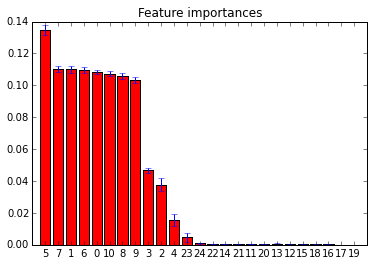

Feature ranking:
	Feature	Importance	Header
    1.	  5	(0.134886)	ListPrice
    2.	  7	(0.110343)	GeoLon
    3.	  1	(0.109959)	LivingArea
    4.	  6	(0.109884)	GeoLat
    5.	  0	(0.108460)	ListingId
    6.	  10	(0.107353)	TimeToClose
    7.	  8	(0.105812)	CloseDateInt
    8.	  9	(0.103307)	ListDateInt
    9.	  3	(0.046668)	NumBaths
    10.	  2	(0.037733)	NumBedrooms
    11.	  4	(0.015611)	ExteriorStories
    12.	  23	(0.004628)	PoolOrd
    13.	  24	(0.000817)	DwellingTypeOrd
    14.	  22	(0.000531)	DwellingType_Townhouse
    15.	  14	(0.000513)	Pool_Private
    16.	  21	(0.000486)	DwellingType_Single Family - Detached
    17.	  11	(0.000480)	Pool_Both Private & Community
    18.	  20	(0.000473)	DwellingType_Patio Home
    19.	  13	(0.000458)	Pool_None
    20.	  12	(0.000393)	Pool_Community
    21.	  15	(0.000355)	DwellingType_Apartment Style/Flat
    22.	  18	(0.000327)	DwellingType_Mfg/Mobile Housing
    23.	  16	(0.000303)	DwellingType_Gemini/Twin Home
    24.	  17	(0.000114)	Dwellin

In [82]:
from sklearn.datasets import make_classification
from sklearn.ensemble import ExtraTreesClassifier

# Build a forest and compute the feature importances
forest = ExtraTreesClassifier(n_estimators=10,  # 250 by default
                              random_state=0)

forest.fit(X, y)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

# Print the feature ranking
print("Feature ranking:")
print("\tFeature\tImportance\tHeader")

for f in range(X.shape[1]):
    print("    %d.\t  %d\t(%f)\t%s" % (f+1, indices[f], importances[indices[f]], headers[indices[f]]))

In [64]:
## Wait Until Feature Reduction Calculation completes!!!
## If you see the feature order change you need more trees!!!

## Drop features and see how mean-squared-error responds 
cutoff = 0.016  # Importance 
cols = []
cols = [i for i in indices if importances[i] < cutoff]
if len(cols) == 0:
    pass
else: X = X.drop(X.columns[cols],axis=1)
headers = X.dtypes.index
print(cols)
cols = []

[]


In [ ]:
## Repeat Feature Reduction? If not, continue. 

In [ ]:
## Debug
#headers
#X.head(1)


## Regression Model: Random Forest

In [16]:
## Test and Training Sets
## Isn't necessary for Random Forests, save for other algos.
#X_train, X_test, y_train, y_test = train_test_split(X, y, 
#                                                    test_size=0.33,
#                                                    random_state=0)

In [16]:
## Train Random Forest
rgr = RandomForestRegressor(n_estimators=100, 
                            max_features=None,
                            criterion='mse',
                            bootstrap=True,
                            oob_score=True,
                            n_jobs=-1,  # Run on all available cores
                            random_state=0)
y_pred = rgr.fit(X,y).predict(X)

# Attributes
score = rgr.score(X, y)
print(score) # R^2, coefficient of determination of the prediction

0.997755968809


## Benchmarks:

0.997755968809 -- All Features  
0.997678529408 -- No Dummies  
0.997587756988 -- No hot-encoding  


In [21]:
## Plot Resulting Prediction vs. Test(Actual)
## Isn't necessary for Random Forests, save for test/train data challenges.

#plt.figure(figsize=(6,6))

#plt.scatter(y_test, y_pred, color='blue', s=5, edgecolor='none')
#plt.xlim(200000,550000)
#plt.ylim(200000,550000)
#plt.grid(True)
#plt.ylabel('y_fit, ClosePrice [USD]')
#plt.xlabel('y_test, ClosePrice [USD]')
#plt.title('y_pred vs. y_test')
#plt.axes().set_aspect('equal') # 'datalim'
#plt.show()

## Performance of Regression(s)

In [22]:
## Error Measurement: Variance between Prediction and Actual ClosePrice
## Isn't necessary for Random Forests, save for other algos.
#mean_squared_error(y_test, y_pred)

### Improvements to Model are reductions in Mean-Squared-Error

Factor Reduction:
   
    mse = 424,396,940 -- Hot-Encoding and Dummy variables  
          438,694,298 -- Just Hot-Encoded 0-n  
          474,807,597 -- .003 # Just PoolOrd
          437,460,043 -- .010 # remove PoolOrd
     -->  407,818,603 -- .025 # remove ExteriorStories <-- Best Model!
          463,484,751 -- .025 # Remove NumBedrooms
          418,513,664 -- .06  # Remove NumBaths
          457,169,976 -- .112 # Drop ListDateInt  
          477,384,686 --  # Drop CloseDateInt  
          426,226,815 -- .122 # Dropped ListingId,TimeToClose,CloseDateInt,ListDateInt  
          693,571,986 -- ???? # Just ListPrice  
          
Study of 'PublicRemarks', n-gram collection and vectorization:
    mse = ???  

In [23]:
## Evaluate PCA to Determine Pricipal Components
from sklearn.decomposition import PCA
pca = PCA(n_components=25)  # Number of compenent vectors in the training set
pca.fit(X)
PCA(copy=True, n_components=25, whiten=False)
#print(pca.explained_variance_ratio_) 
# Note: first two contain 98% of the variance

PCA(copy=True, n_components=25, whiten=False)

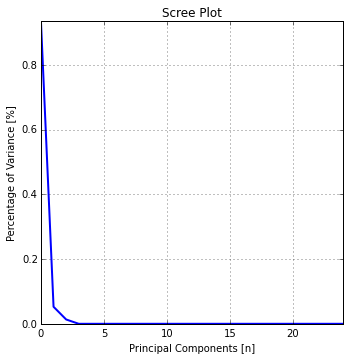

In [24]:
## Plot the PCA spectrum
plt.figure(figsize=(6, 6))
plt.clf()
plt.axes([.2, .2, .7, .7])
plt.plot(pca.explained_variance_ratio_, linewidth=2) # pca.explained_variance_
plt.axis('tight')
plt.grid(True)
plt.title('Scree Plot')
plt.xlabel('Principal Components [n]')
plt.ylabel('Percentage of Variance [%]') # for each eigenvector

## What is Next?

After model is finalized, test on whole dataset.

Try GBM (Gradient Boosted Machines) next and GLM (Generalized Linear Model). GBM Normally beats deep learning and GLM (and random forest with optimization). Use Mean-squared-error to compare regression models.  
Apply a meta-learner specifically a GLM (nnps) to stack/ensemble the algorithms.

Impute missing entries...

Review generalized Low-rank model (GLRM).

Specify a custom loss function .. i.e. "holst" (quadratic and linear)


### Missing data:  
Source: http://artsci.wustl.edu/~gradconf/conf2015/Papers2015/1_3_Ho.pdf    
Age of home  
% of neighbors with bachelors  
% of neighbors with mastors/adv. degree  
quality of neighborhood schools  
fireplace  

### Requested features:
early stopping
k-fold cross-validation

In [17]:
## Memoizer - support of slow calculating functions
def memoize(obj):
    """General-purpose cache for classes, methods, and functions."""
    cache = obj.cache = {}

    def memoizer(*args, **kwargs):
        """Do cache lookups and populate the cache in the case of misses."""
        key = args[0] if len(args) is 1 else args
        if key not in cache:
            cache[key] = obj(*args, **kwargs)
        return cache[key]

    # Make the memoizer func masquerade as the object we are memoizing.
    # This makes class attributes and static methods behave as expected.
    for k, v in obj.__dict__.items():
        memoizer.__dict__[k] = v.__func__ if type(v) is staticmethod else v
    return memoizer

## Regression Model: Gradient Boosting Regressor

In [20]:
## Gradient Boosting Regressor
from sklearn.ensemble import GradientBoostingRegressor

## Train Gradient Boosting Regressor
#Ex.
#gbr = GradientBoostingRegressor(loss=‘huber’,
#                                learning_rate=0.1,
#                                n_estimators=3000, #as high as possible
#                                max_depth=3,
#                                max_features=None,
#                                criterion='mse',
#                                n_jobs=-1,
#                                random_state=0)

## Hyperparameter Grid Search
from sklearn.grid_search import GridSearchCV
param_grid = {'learning_rate': [.1, 0.05, 0.02, 0.01],
              'max_depth': [4,6],
              'min_samples_leaf': [3, 5, 9, 17],
              'max_features': [1.0, 0.3, 0.1]}
gbr = GradientBoostingRegressor(n_estimators=100)
gs_cv = GridSearchCV(gbr, param_grid).fit(X,y)
# Best hyperparameter setting
gs_cv.best_params_

# Next, set 'n_estimators' even higher and tune 'learning_rate'                


{'learning_rate': 0.1,
 'max_depth': 4,
 'max_features': 1.0,
 'min_samples_leaf': 9}

In [ ]:
########### Dump #########
## CV example:

## Random Forest with k-fold Cross-Validation
start_time = time.time()

regressor = RandomForestRegressor(n_estimators=100, 
                            max_features=None,
                            criterion='mse',
                            bootstrap=True,  # 'with replacement'
                            oob_score=True,
                            n_jobs=-1,  # Run on all available cores
                            random_state=0)

kf_total = cross_validation.KFold(len(X), 
                                  n_folds=10, 
                                  indices=True, 
                                  shuffle=True, 
                                  random_state=0)
cross_val_score = cross_validation.cross_val_score(regressor, X, y, cv=kf_total, n_jobs=1)


stop_time = time.time()
print("example run in %.2fs" % (stop_time - start_time))


## Attributes of RandomForest Cross-Validation
# Cross_val-score == Deviance (r^2 error)
Print(cross_val_score)
#score = regressor.score(X_validation, y_validation)
print(score) # R^2, coefficient of determination of the prediction

#out_of_bag_prediction_for_y = regressor.oob_prediction_
#print(mean_squared_error(out_of_bag_prediction_for_y, y_test))

In [ ]:
## Attributes
#score = rgr.train_score_(X, y)  #Array of deviance (loss) of model at iteration i.
#print(score) # R^2, coefficient of determination of the prediction

In [ ]:
## Plot Feature Importance
gbr.feature_importance_  # array

#plot(features,relative importance)

In [ ]:
## Plot Test and Train loss (error) vs. n_estimators

MSE: 6.6424


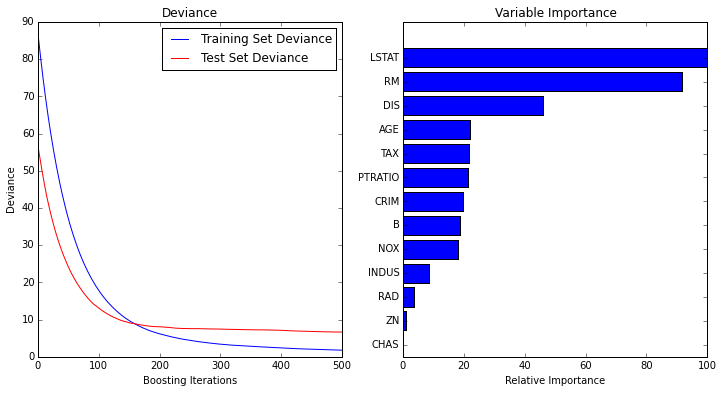

In [4]:
#print(__doc__)

# Author: Peter Prettenhofer <peter.prettenhofer@gmail.com>
#
# License: BSD 3 clause

import numpy as np
import matplotlib.pyplot as plt

from sklearn import ensemble
from sklearn import datasets
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error

###############################################################################
# Load data
boston = datasets.load_boston()
X, y = shuffle(boston.data, boston.target, random_state=13)
X = X.astype(np.float32)
offset = int(X.shape[0] * 0.9)
X_train, y_train = X[:offset], y[:offset]
X_test, y_test = X[offset:], y[offset:]

###############################################################################
# Fit regression model
params = {'n_estimators': 500, 'max_depth': 4, 'min_samples_split': 1,
          'learning_rate': 0.01, 'loss': 'ls'}
clf = ensemble.GradientBoostingRegressor(**params)

clf.fit(X_train, y_train)
mse = mean_squared_error(y_test, clf.predict(X_test))
print("MSE: %.4f" % mse)

###############################################################################
# Plot training deviance

# compute test set deviance
test_score = np.zeros((params['n_estimators'],), dtype=np.float64)

for i, y_pred in enumerate(clf.staged_predict(X_test)):
    test_score[i] = clf.loss_(y_test, y_pred)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, clf.train_score_, 'b-',
         label='Training Set Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, test_score, 'r-',
         label='Test Set Deviance')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Deviance')

###############################################################################
# Plot feature importance
feature_importance = clf.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, boston.feature_names[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()